# **Predição de Perfomance de Estudantes**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
data = pd.read_csv('../input/student-data/student_data.csv')
copyData = data.copy()

**DADOS:**

**Student ID.
Study Hours per Week**: Horas de estudo semanais (tem negativos)

**Attendance Rate**: Porcentagem de presença (tem valores maiores que 100)

**Previous Grades**: Média das notas passadas (tem valores maiores que 100)

**Participation in Extracurricular Activities**: Atividades Extracurriculares

**Parent Education Level**: Maior nível educacional dos pais

**Passed**: Passou ou não.

# 1. Tratando Dados

**1.1 Checar quantos valores diferentes em cada coluna, quantas linhas duplicadas e remover ID porque é irrelevante para a análise**

In [3]:
print(copyData.nunique())

print("Duplicated Rows:",copyData.duplicated().sum())
copyData = copyData.drop(columns='Student ID', axis=1)

Student ID                                     40000
Study Hours per Week                             355
Attendance Rate                                 1235
Previous Grades                                  956
Participation in Extracurricular Activities        2
Parent Education Level                             5
Passed                                             2
dtype: int64
Duplicated Rows: 0


**1.2 Transformar valores negativos para positivos**

In [4]:
negative_hours = copyData[copyData['Study Hours per Week'] < 0]
print(negative_hours.head())
copyData['Study Hours per Week'] = copyData['Study Hours per Week'].abs()

     Study Hours per Week  Attendance Rate  Previous Grades  \
74                   -3.1             37.3             43.1   
236                  -0.1             50.0             65.9   
262                  -6.2             98.7             26.2   
366                  -1.0            101.5             66.8   
382                  -0.6             34.9              NaN   

    Participation in Extracurricular Activities Parent Education Level Passed  
74                                           No                 Master    Yes  
236                                          No               Bachelor     No  
262                                         Yes            High School    Yes  
366                                          No                    NaN     No  
382                                         Yes                 Master    Yes  


**1.3 Presença maior que 100% vai ficar igual a 100%**

In [5]:
# Limitar os valores da coluna 'Attendance Rate' a um máximo de 100
print(copyData.loc[366])
copyData['Attendance Rate'] = copyData['Attendance Rate'].clip(upper=100)

print(copyData.loc[366])


Study Hours per Week                             1.0
Attendance Rate                                101.5
Previous Grades                                 66.8
Participation in Extracurricular Activities       No
Parent Education Level                           NaN
Passed                                            No
Name: 366, dtype: object
Study Hours per Week                             1.0
Attendance Rate                                100.0
Previous Grades                                 66.8
Participation in Extracurricular Activities       No
Parent Education Level                           NaN
Passed                                            No
Name: 366, dtype: object


**1.4 Linhas onde a média das notas anteriores é maior que 100 serão removidas**

In [6]:
print(copyData.loc[185])
copyData = copyData[copyData['Previous Grades'] <= 100]

Study Hours per Week                                  13.6
Attendance Rate                                       59.4
Previous Grades                                      102.0
Participation in Extracurricular Activities            Yes
Parent Education Level                         High School
Passed                                                  No
Name: 185, dtype: object


**1.5 Eliminar valores nulos, substituindo pelo valor da média nas variáveis numéricas, por "No" para a variável Participação de Atividades Extracurriculares, por "High School" para a variável Nível de Escolaridade dos Pais e eliminando as linhas da variável Passed**

In [7]:
count = 0
for variavel in copyData.columns:
    if count < 3:
        copyData[variavel] = copyData[variavel].fillna(copyData[variavel].mean())
        count += 1
    elif count == 3:
        copyData[variavel] = copyData[variavel].fillna('No')
        count += 1
    elif count == 4:
        copyData[variavel] = copyData[variavel].fillna('High School')
        count += 1
    elif count == 5:
        copyData = copyData.dropna(subset=['Passed'])

**1.6 Tratar variáveis não numéricas assinalando valores binários (variáveis categóricas)**

In [8]:
copyData['Passed'] = copyData['Passed'].map({'Yes': 1, 'No': 0})
copyData['Participation in Extracurricular Activities'] = copyData['Participation in Extracurricular Activities'].map({'Yes': 1, 'No': 0})

**1.7 Atribuir valores numéricos para a variável 'Parent Education Level'**

In [9]:
le = LabelEncoder()

copyData['Parent Education Level'] = le.fit_transform(copyData['Parent Education Level'])
print(copyData.head())

   Study Hours per Week  Attendance Rate  Previous Grades  \
0                  12.5         74.14879             75.0   
1                   9.3         95.30000             60.6   
2                  13.2         74.14879             64.0   
3                  17.6         76.80000             62.4   
4                   8.8         89.30000             72.7   

   Participation in Extracurricular Activities  Parent Education Level  Passed  
0                                            1                       4       1  
1                                            0                       3       0  
2                                            0                       0       0  
3                                            1                       1       0  
4                                            0                       4       0  


* 0 = Associate
* 1 = Bachelor
* 2 = High School
* 3 = Master
* 4 = Doctorate

**Verificar se o tratamento deu certo**

In [10]:
print(copyData.isnull().sum())
print(copyData.nunique())

Study Hours per Week                           0
Attendance Rate                                0
Previous Grades                                0
Participation in Extracurricular Activities    0
Parent Education Level                         0
Passed                                         0
dtype: int64
Study Hours per Week                           275
Attendance Rate                                867
Previous Grades                                819
Participation in Extracurricular Activities      2
Parent Education Level                           5
Passed                                           2
dtype: int64


# 2. Analisando dados numéricos

In [11]:
print('Média de horas de estudo semanais:',copyData['Study Hours per Week'].mean().round(2))
print('Média da presença:',copyData['Attendance Rate'].mean().round(2))
print('Média de notas anteriores:',copyData['Previous Grades'].mean().round(2))

Média de horas de estudo semanais: 10.06
Média da presença: 74.14
Média de notas anteriores: 64.67


# Em gráfico

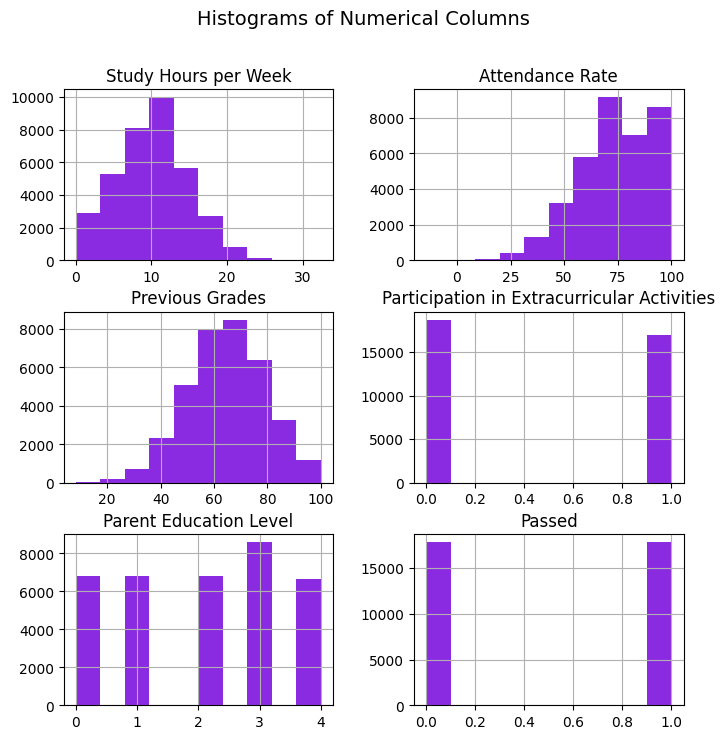

In [12]:
numerical_df = copyData.select_dtypes(include=['float64', 'int64'])

numerical_df.hist(color='#8A2BE2', figsize=(8, 8), bins=10)
plt.suptitle('Histograms of Numerical Columns', fontsize=14)
plt.show()

In [13]:
target_dis = copyData['Passed'].value_counts().reset_index()
target_dis.columns = ['Passed', 'Count']

custom_colors = ['#F0A500', '#F26D3F']

fig = px.bar(target_dis, x='Passed', y='Count', title='Nº de alunos que passaram e não passaram', color='Passed')

fig.update_layout(xaxis_title='Passou', yaxis_title='Alunos', width = 500, height = 500)

fig.show()

# Analisando variáveis Categóricas

In [14]:
parti = copyData['Participation in Extracurricular Activities'].value_counts().reset_index()
parti.columns = ['Participation in Extracurricular Activities', 'Count']

custom_colors = ['#F0A500', '#F26D3F']

fig = px.bar(parti, x='Participation in Extracurricular Activities', y='Count', 
             title='Atividades Extracurriculares',
             color='Participation in Extracurricular Activities', 
             color_discrete_sequence=custom_colors)

fig.update_layout(
    xaxis_title='Atividades Extracurriculares',
    yaxis_title='Nº de Alunos',
    width=800,   
    height=500   
)

fig.show()

In [15]:
parent_edu_count = copyData['Parent Education Level'].value_counts().reset_index()
parent_edu_count.columns = ['Parent Education Level', 'Count']

custom_colors = ['#F0A500', '#F26D3F', '#29A0B1', '#C25A7C', '#6A0572']

fig = px.bar(parent_edu_count, x='Parent Education Level', y='Count', 
             title='Nível Educacional dos Pais',
             color='Parent Education Level', 
             color_discrete_sequence=custom_colors)

fig.update_layout(
    xaxis_title='0 - Associate 1 - Bachelor 2 - High School 3 - Master 4 - Doctorate',
    yaxis_title='Count',
    width=800,   
    height=500   
)

fig.show()

# Variáveis Teste e Alvo

In [16]:
y = copyData.Passed
x = copyData.drop(columns=['Passed'], axis=1)
print(y)
print(x)

0        1
1        0
2        0
3        0
4        0
        ..
39994    0
39995    0
39996    1
39997    0
39999    1
Name: Passed, Length: 35660, dtype: int64
       Study Hours per Week  Attendance Rate  Previous Grades  \
0                      12.5         74.14879             75.0   
1                       9.3         95.30000             60.6   
2                      13.2         74.14879             64.0   
3                      17.6         76.80000             62.4   
4                       8.8         89.30000             72.7   
...                     ...              ...              ...   
39994                   5.1         92.10000             46.1   
39995                  15.6         93.80000             51.4   
39996                  11.3         66.40000             64.2   
39997                  13.1         65.60000             38.1   
39999                  11.8         55.10000             68.5   

       Participation in Extracurricular Activities  Pare

**Separando as variáveis em de treino e teste 80/20**

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2)